In [1]:
import os
os.getcwd()

'/home/user/Documentos/Sensoramiento del sistema remoto terrestre 1/Final'

In [2]:
#! pip install matplotlib

In [3]:
#Librerias que vamos a utilizar
import numpy as np
import pyhdf.SD
from pyhdf.SD import SD,SDC #Necesitamos la libreria pyhdf para leer archivos y SD una clase
import glob #una libreria que usamos
import pandas as pd
import matplotlib.pyplot as plt
import re #liberia para regex que luego usaremos en texto

In [4]:
def lee_archivo(File):
    archivo = SD(File,SDC.READ)
    return archivo

def busca_meta_data(File):
    meta_data = File.attributes()["CoreMetadata.0"]
    return meta_data

#Testeo funcion
def fecha_archivo(File):
    meta_data = busca_meta_data(File)
    
    #Generamos una regex con el formato \b(?:word_a\W+(?:\w+\W+){0,20}?word_b)\b
    #Busca en meta_data una seccion del texto donde se halla informacion sobre la fecha
    #en la que se inicio el scaneo
    info_inicio_hora = re.search(r'\b(?:RANGEBEGINNINGDATE\W+(?:\w+\W+){0,20}?RANGEBEGINNINGDATE)\b',meta_data)[0]

    patron_fecha = r'(\d{4})-(\d{2})-(\d{2})'
    
    fecha = re.search(patron_fecha,meta_data)[0]
    
    return fecha


def hora_archivo(File):
    
    #Al ingresar el File hdf nos devuelve la hora en la que inicio el scaneo
    #de los datos
    meta_data = busca_meta_data(File)
    
    #Generamos una regex con el formato \b(?:word_a\W+(?:\w+\W+){0,20}?word_b)\b
    #Busca en meta_data una seccion del texto donde se halla informacion sobre el inicio
    #de la hora del scaneo
    info_inicio_hora = re.search(r'\b(?:RANGEBEGINNINGTIME\W+(?:\w+\W+){0,20}?RANGEBEGINNINGTIME)\b',meta_data)[0]

    patron_hora = r'(\d{2}):(\d{2}):(\d{2})'
    
    hora = re.search(patron_hora,info_inicio_hora)[0]
    
    return hora  


def visualiza_hdf(File):
    
    #El modulo datasets (proviene de la libreria pyhdf) me devuelve informacion sobre que
    #hay dentro del hdf. 
    datasets = {"Datasets": list(File.datasets().keys())}
    
    #Lo transformamos a un dataframe para visualizar
    info_file = pd.DataFrame(datasets)
    
    return info_file


#Funcion que pide como argumento un archivo hdf y el dataset que queramos

def selecciona_sds_hdf(File,sds):
    
    #Seleccionamos el dataset con "select" metodo de la libreria pyhdf
    sds_seleccionado = File.select(sds)
    
    return sds_seleccionado

#Toma como argumento un archivo hdf y el dataset que desee extraer

def extrae_datos_hdf(File,sds):
    
    #Seleccionamos el dataset con la funcion
    dataset = selecciona_sds_hdf(File,sds)
    
    #Extraemos los datos con el metodo get de pyhdf
    sds_datos = dataset.get()
    
    #Devuelve los datos y su dimension
    return sds_datos,sds_datos.shape

def selecciona_atributos_sds(File,sds):
    
    #Seleccionamos el dataset
    dataset = selecciona_sds_hdf(File,sds)
    
    #Utilizamos el metodo attribute, nos devuelve un diccionario con una descripcion
    #global de cada atributo adjunto al archivo hdf
    dic_atributos = dataset.attributes()
    
    return dic_atributos

#Input : File y un dataset
def muestra_atributos_sds(File,sds):
    
    dic_atributos = selecciona_atributos_sds(File,sds)
        
    #Tomamos las llaves y valores del diccionario y los transformamos en listas
    #para luego generar una tabla y visualizarlo
    columna1 = list(dic_atributos.keys())
    columna2 = list(dic_atributos.values())
    
    #Generamos una tabla/dataframe
    df = pd.DataFrame({"":columna1,"Atributos":columna2})
    df = df.set_index("")
    
    #Regresa una tabla donde se muestran los atributos del dataset
    return df


#Se elige un file hdf, sds: el dataset que queramos y el atributo del dataset
def extrae_atributos_sds(File,sds,atributo):
    
    #Utilizamos la funcion para generar un diccionario con los atributos
    dic_atributos = selecciona_atributos_sds(File,sds)
    
    #Del diccionario elegimos el atributo que queremos
    attr = dic_atributos[atributo]
    
    #Devuelve una lista con los valores de mi atributo
    return attr


#Extrae los valores de la banda seleccionada ya convertidos a reflectancia

#File hdf, sds: dataset,canal deseado, nombre de atributo con las bandas
def extrae_banda(File,sds,band,nombre_atributo):
    
    #Extraemos los valores de reflectancia sin conversion
    REF = extrae_datos_hdf(File,sds)[0]
    
    #Extraemos los numeros de bandas que tenemos. Ej:band 1, band2
    #Spliteamos para operar en ellas
    n_bands = extrae_atributos_sds(File,sds,nombre_atributo).split(",")
    
    #Elegimos la banda
    
    posicion_band = n_bands.index(str(band))
    
    
    #Hacemos la conversion
    
    rad_off_ref= extrae_atributos_sds(File,sds,"reflectance_offsets")[posicion_band]
    
    rad_scales_ref = extrae_atributos_sds(File,sds,"reflectance_scales")[posicion_band]
    
    canal = rad_scales_ref * (REF[posicion_band,:,:] - rad_off_ref)
    
    return canal


def indice_nbr(File,sds,nombre_atributo):
    
    #Extraemos las bandas con las cuales vamos a trabajar
    canal_5 = extrae_banda(File,sds,5,nombre_atributo)
    canal_7 = extrae_banda(File,sds,7,nombre_atributo)
    
    #Calculamos el indice NBR
    nbr = (canal_5 - canal_7) / (canal_5 + canal_7)
    
    #array con los valores de nbr
    return nbr  

In [5]:
muestra_atributos_sds(File,sds)

NameError: name 'File' is not defined

## NBR Modis

In [5]:
#Ruta donde se encuentran los archivos hdf
DataPath = 'archivos'

#Generamos una variable con todos los archivos de la carpeta
Filelist = glob.glob(DataPath+'/MODO21'+'/*')

#Ruta donde se encuentran los archivos hdf
DataPath = 'archivos'

#Generamos una variable con todos los archivos de la carpeta
Filelist_geo = glob.glob(DataPath+'/MODO3'+'/*')

In [6]:
[Filelist, Filelist_geo]

[['archivos/MODO21/MOD021KM.A2022255.1345.006.2022256033835.hdf',
  'archivos/MODO21/MOD021KM.A2022095.1350.006.2022096142803.hdf'],
 ['archivos/MODO3/MOD03.A2022095.1350.061.2022096142223.hdf',
  'archivos/MODO3/MOD03.A2022255.1345.006.2022256002625.hdf']]

In [7]:
#Archivo con datos previos al incendio
bef_fire = lee_archivo(Filelist[1])

#Archivo con datos georeferenciados previos al incendio
bef_fire_geo = lee_archivo(Filelist_geo[0])

#Hora y fecha 
#bef_fire_date = fecha_archivo(bef_fire)

bef_fire_hour = hora_archivo(bef_fire)
bef_fire_date = fecha_archivo(bef_fire)

#Latitud y longitud
bef_fire_lat = extrae_datos_hdf(bef_fire_geo,"Latitude")[0]
bef_fire_lon = extrae_datos_hdf(bef_fire_geo,"Longitude")[0]

In [9]:
#visualiza_hdf(bef_fire)
#muestra_atributos_sds(bef_fire,"EV_500_Aggr1km_RefSB")

In [8]:
#Calculamos Indice normalizado de area quemada
bef_fire_nbr = indice_nbr(bef_fire,"EV_500_Aggr1km_RefSB","band_names")

# Ploteo

In [9]:
from matplotlib.ticker import FixedLocator
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [31]:
# Cargamos los límites de países y provincias para poder graficarlas en los mapas

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none',edgecolor='black')

countries = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_0_countries',
        scale='10m',
        facecolor='none',edgecolor='white')

In [17]:
bef_fire_lon.shape

(2030, 1354)

In [14]:
[Filelist, Filelist_geo]

[['archivos/MODO21/MOD021KM.A2022255.1345.006.2022256033835.hdf',
  'archivos/MODO21/MOD021KM.A2022095.1350.006.2022096142803.hdf'],
 ['archivos/MODO3/MOD03.A2022095.1350.061.2022096142223.hdf',
  'archivos/MODO3/MOD03.A2022255.1345.006.2022256002625.hdf']]

In [10]:
#Archivo con datos post al incendio
aft_fire = lee_archivo(Filelist[0])

#Archivo con datos georeferenciados post al incendio
aft_fire_geo = lee_archivo(Filelist_geo[1])


#Hora y fecha 
aft_fire_date = fecha_archivo(aft_fire)

aft_fire_hour = hora_archivo(aft_fire)

#Latitud y longitud
aft_fire_lat = extrae_datos_hdf(aft_fire_geo,"Latitude")[0]
aft_fire_lon = extrae_datos_hdf(aft_fire_geo,"Longitude")[0]

In [11]:
#Calculamos Indice normalizado de area quemada
aft_fire_nbr = indice_nbr(aft_fire,"EV_500_Aggr1km_RefSB","band_names")


 ## Fecha
 A la funcion fecha, le doy el formato que mas me guste.

In [12]:
fecha = aft_fire_date
fecha

'2022-09-13'

In [13]:
from datetime import date
from datetime import datetime

In [14]:
d = datetime.strptime(fecha, '%Y-%m-%d')
d2 = d.strftime("%d/%m/%Y")
d2

'13/09/2022'

## Interpolación
Uso scipy para regrillar los datos de del post-fire. Falta hacer del pre-fire (Fer :) ). Los valor xi e yi son la nueva grilla (la que deberia ser común entre el post-fire y pre-fire), y el zi es en realidad el valor de nbr interpolado (no estaría mal cambiarle el nombre así es mas autoexplicativo).

In [18]:
import scipy
# bef_fire_lon.shape
# bef_fire_lat.shape

(2030, 1354)

In [23]:
aft_fire_nbr.size

2748620

In [42]:
#(aft_fire_lon, aft_fire_lat)
#lon = np.arange(-180, 180, 0.5)
#lat = np.arange(-90, 90, 0.5)

#lon = np.reshape(lon, [lon.size,1])
#lat = np.reshape(lat, [1,lat.size])

#x = np.repeat(lon, 180, axis=1)
#x.shape
#y = np.repeat(lat, lon.size, axis = 0)
#y.shape
#from scipy.interpolate import griddata
from scipy.interpolate import griddata
## Todo lo que está arriba comentado son pruebas, no las uso.

#x_p y x_p son los valores de lon y lat originales del post-fire
x_p = np.reshape(aft_fire_lon, aft_fire_lon.size)  #vuelvo array de 1D
y_p = np.reshape(aft_fire_lat, aft_fire_lat.size)  #idem
# points = np.array([x_p, y_p]).shape

# Los valores originales de NBR a interpolar
values = np.reshape(aft_fire_nbr, aft_fire_nbr.size)  #aca lo vuelvo un array de 1D para entrarlo en la funcion
values.shape

#busco los maximos y mínimos de este lon-lat para despues armar la nueva grilla
xmin,xmax,ymin,ymax = min(x_p),max(x_p),min(y_p),max(y_p)

#size of 1 m grid
    # Generate a regular grid to interpolate the data.
#genero la nueva grilla
xi = np.arange(xmin, xmax, 0.005)#, endpoint=False)
yi = np.arange(ymin, ymax, 0.005)
xi, yi = np.meshgrid(xi, yi)

# Interpolate the values of z for all points in the rectangular grid
#Interpolo
aft_int_fire_nbr = griddata((x_p, y_p), values, (xi, yi),method='linear')

# En resumen, al plotear, zi es lo que antes era NBR, xi es lo que antes eran tus lon e yi
# lo que eran tus lat.
# La idea es hacer lo mismo, pero usando el mismo xi, yi (misma grilla), e interpolar el pre-fire
# con esto se tendría en ppio todo (lo pense, no lo hice, asique puede salir mal)

In [43]:
%%time
x_p = np.reshape(bef_fire_lon, bef_fire_lon.size)  #vuelvo array de 1D
y_p = np.reshape(bef_fire_lat, bef_fire_lat.size)  #idem
# points = np.array([x_p, y_p]).shape
# Los valores originales de NBR a interpolar
values = np.reshape(bef_fire_nbr, bef_fire_nbr.size)  #aca lo vuelvo un array de 1D para entrarlo en la funcion
values.shape

bef_int_fire_nbr = griddata((x_p, y_p), values, (xi, yi),method='linear')

CPU times: user 53.4 s, sys: 11.6 s, total: 1min 5s
Wall time: 46.8 s


In [44]:
xi.shape
#yi.shape
#bef_int_fire_nbr.shape
#aft_int_fire_nbr.shape

(4247, 6012)

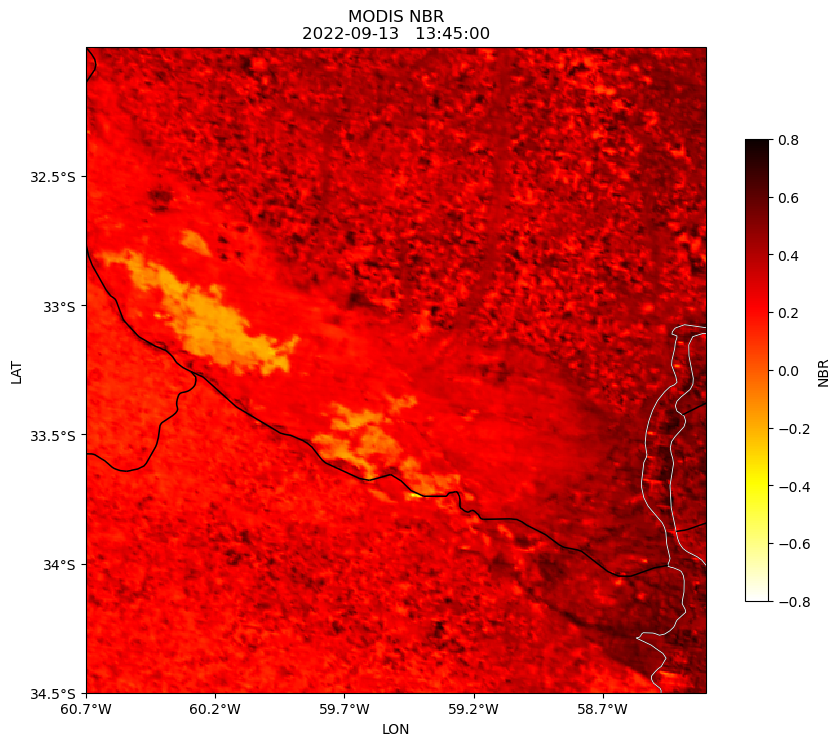

In [46]:
# Definimos los limites del area a visualizar
latnorth=-32
latsouth=-34.5
lonwest=-60.7
loneast=-58.3

fig=plt.figure(figsize=(10,10))
    
ax1 = plt.subplot(1, 1, 1, projection = ccrs.PlateCarree())
    
# Definimos el área de graficado y a qué proyección hay que transformar las coordenadas lat/lon

ax1.set_extent([lonwest, loneast, latsouth, latnorth], crs=ccrs.PlateCarree())

# Graficamos

#Agregamos ejes
ax1.set_title("MODIS NBR\n"+str(aft_fire_date)+"   "+str(aft_fire_hour))
ax1.set_ylabel("LAT")
ax1.set_xlabel("LON")
    
cm=ax1.pcolormesh(xi,yi,aft_int_fire_nbr,cmap='hot_r',vmin=-0.8,vmax=0.8)

# Agregamos la línea de costas
ax1.coastlines(resolution='10m',linewidth=0.8)
    
# Agregamos los límites de los países
ax1.add_feature(countries,linewidth=0.6)
    
# Agregamos los límites de las provincias
ax1.add_feature(states_provinces,linewidth=1.1)
    
# Definimos donde aparecen los ticks con las latitudes y longitudes
ax1.set_yticks(np.arange(latsouth,latnorth,0.5), crs=ccrs.PlateCarree())
ax1.set_xticks(np.arange(lonwest,loneast,0.5), crs=ccrs.PlateCarree())
    
# Le damos formato a las etiquetas de los ticks
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)

# Agregamos la barra de colores 
cbar=plt.colorbar(cm,shrink=0.6)
cbar.set_label('NBR',fontsize=10)

In [47]:
dnbr = bef_fire_nbr - aft_fire_nbr
dnbr_int = bef_int_fire_nbr - aft_int_fire_nbr

In [24]:
dnbr_colors = ['g', 'lawngreen', 'palegreen', 'khaki', 'y', 'peru', 'r']

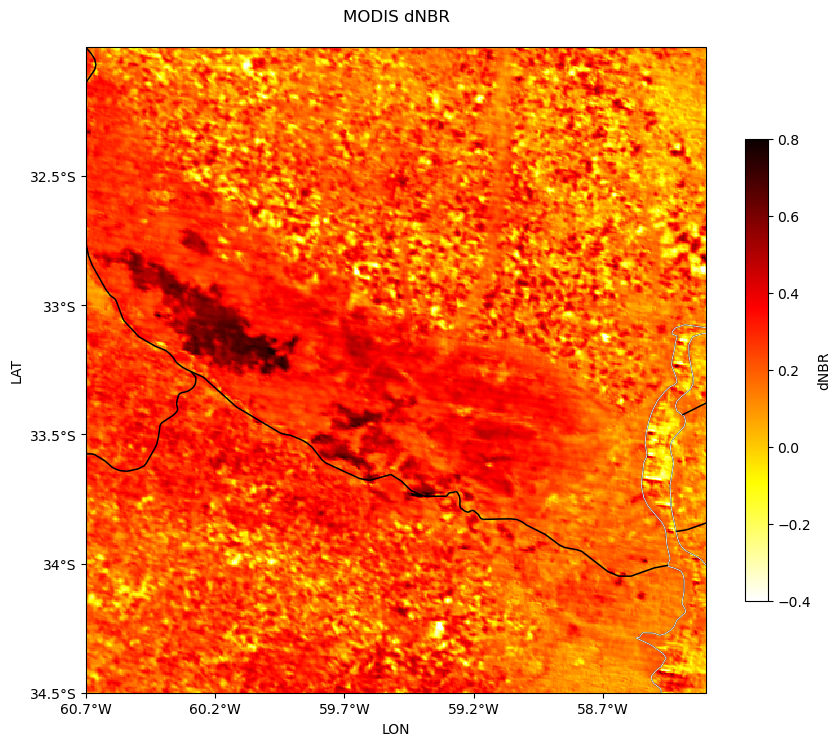

In [48]:
# Definimos los limites del area a visualizar
latnorth=-32
latsouth=-34.5
lonwest=-60.7
loneast=-58.3

fig=plt.figure(figsize=(10,10))
    
ax1 = plt.subplot(1, 1, 1, projection = ccrs.PlateCarree())
    
# Definimos el área de graficado y a qué proyección hay que transformar las coordenadas lat/lon

ax1.set_extent([lonwest, loneast, latsouth, latnorth], crs=ccrs.PlateCarree())

# Graficamos

#Agregamos ejes
ax1.set_title("MODIS dNBR\n")
ax1.set_ylabel("LAT")
ax1.set_xlabel("LON")
    
#cm=ax1.pcolormesh(aft_fire_lon,aft_fire_lat,dnbr,cmap='hot_r',vmin=-0.4,vmax=0.8)
cm=ax1.pcolormesh(xi,yi,dnbr_int,cmap='hot_r',vmin=-0.4,vmax=0.8)

# Agregamos la línea de costas
ax1.coastlines(resolution='10m',linewidth=0.8)
    
# Agregamos los límites de los países
ax1.add_feature(countries,linewidth=0.6)
    
# Agregamos los límites de las provincias
ax1.add_feature(states_provinces,linewidth=1.1)
    
# Definimos donde aparecen los ticks con las latitudes y longitudes
ax1.set_yticks(np.arange(latsouth,latnorth,0.5), crs=ccrs.PlateCarree())
ax1.set_xticks(np.arange(lonwest,loneast,0.5), crs=ccrs.PlateCarree())
    
# Le damos formato a las etiquetas de los ticks
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)

# Agregamos la barra de colores 
cbar=plt.colorbar(cm,shrink=0.6)
cbar.set_label('dNBR',fontsize=10)

## Nubosidad

In [13]:
file = bef_fire
file = arch

NameError: name 'arch' is not defined

In [12]:
# Seleccionamos el SDS
sds_obj_IR = file.select('EV_1KM_Emissive') 
# Extraemos los datos del SDS
IR = sds_obj_IR.get() 

IR.shape

NameError: name 'file' is not defined

In [19]:
for key, value in sds_obj_IR.attributes().items():
    if key == 'radiance_offsets':
        radiance_offsets_IR = value  
    if key == 'radiance_scales':
        radiance_scales_IR = value

In [46]:
# CANAL 31 (11.03)
B31 = radiance_scales_IR[10] * ( IR[10,:,:] - radiance_offsets_IR[10] )
B31 = B31*1e6 # Units: Watts/m^2/m/steradian

In [47]:
#Transformo radianza a TB
#=================================================================#

# Estas constantes son las mismas para todo los canales emisivos

c = 2.99792458e8  # Velocidad de la luz en el vacio [m/s]
h = 6.6260755e-34 # Constante de Planck [J s]
k = 1.380658e-23  # Constante de Boltzmann [J/K]

#=================================================================#

#=================================================================#

L = 11.03*1e-6 # Longitud de onda [m]
C1 = h*c
C2 = k*L
C3 = 2*h*np.power(c,2)/np.power(L,5)

TB31 = C1/(C2*np.log((C3/B31)+1))-273 # Temperatura de brillo en K

#=================================================================#


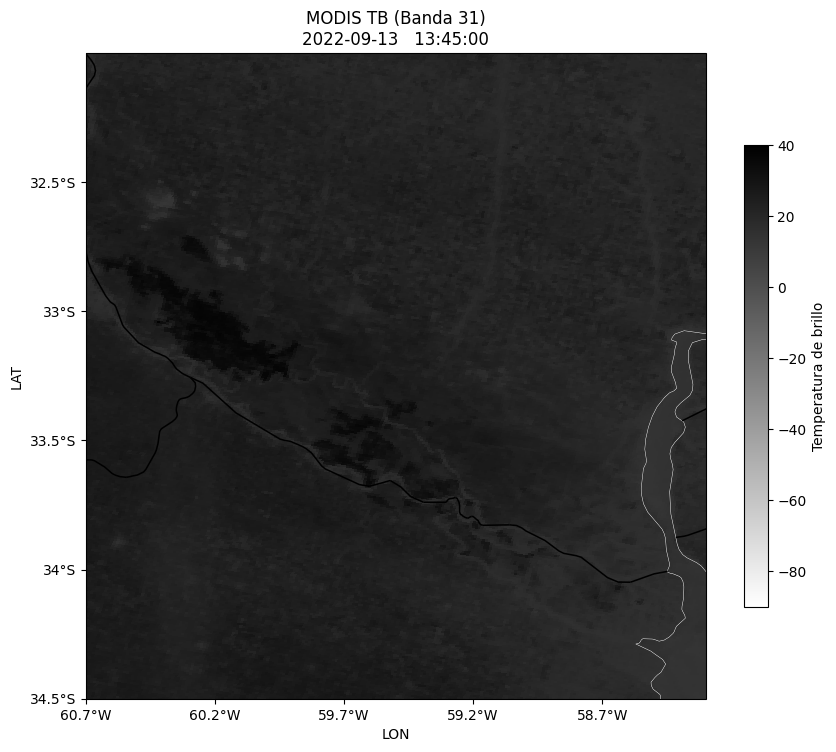

In [42]:
# Definimos los limites del area a visualizar
latnorth=-32
latsouth=-34.5
lonwest=-60.7
loneast=-58.3

fig=plt.figure(figsize=(10,10))
    
ax1 = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
    
# Definimos el área de graficado y a qué proyección hay que transformar las coordenadas lat/lon
    
ax1.set_extent([lonwest, loneast, latsouth, latnorth], crs=ccrs.PlateCarree())

# Graficamos
    
cm=ax1.pcolormesh(aft_fire_lon,aft_fire_lat, TB31,cmap='gray_r',vmin=-90,vmax=40)

# Agregamos la línea de costas
ax1.coastlines(resolution='10m',linewidth=0.6)
    
# Agregamos los límites de los países
ax1.add_feature(countries,linewidth=0.4)
    
# Agregamos los límites de las provincias
ax1.add_feature(states_provinces,linewidth=1.1)

#Agregamos ejes
ax1.set_title("MODIS TB (Banda 31)\n"+str(aft_fire_date)+"   "+str(aft_fire_hour))
ax1.set_ylabel("LAT")
ax1.set_xlabel("LON")
    
# Definimos donde aparecen los ticks con las latitudes y longitudes
ax1.set_yticks(np.arange(latsouth,latnorth,0.5), crs=ccrs.PlateCarree())
ax1.set_xticks(np.arange(lonwest,loneast,0.5), crs=ccrs.PlateCarree())
    
# Le damos formato a las etiquetas de los ticks
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)

# Agregamos la barra de colores 
cbar=plt.colorbar(cm,shrink=0.6)
cbar.set_label('Temperatura de brillo',fontsize=10)

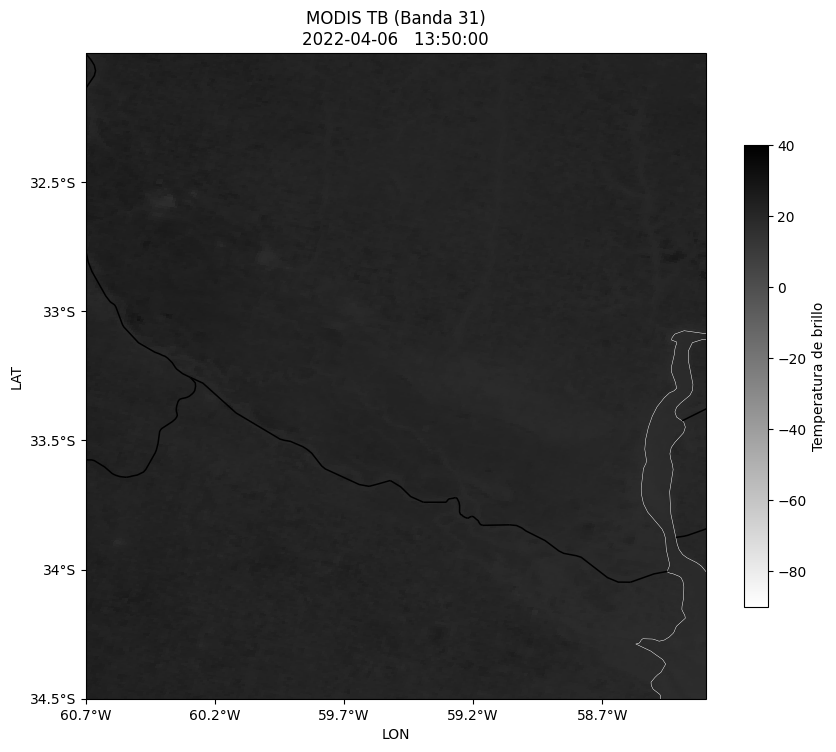

In [48]:
# Definimos los limites del area a visualizar
latnorth=-32
latsouth=-34.5
lonwest=-60.7
loneast=-58.3

fig=plt.figure(figsize=(10,10))
    
ax1 = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
    
# Definimos el área de graficado y a qué proyección hay que transformar las coordenadas lat/lon
    
ax1.set_extent([lonwest, loneast, latsouth, latnorth], crs=ccrs.PlateCarree())

# Graficamos
    
cm=ax1.pcolormesh(bef_fire_lon,bef_fire_lat, TB31,cmap='gray_r',vmin=-90,vmax=40)

# Agregamos la línea de costas
ax1.coastlines(resolution='10m',linewidth=0.6)
    
# Agregamos los límites de los países
ax1.add_feature(countries,linewidth=0.4)
    
# Agregamos los límites de las provincias
ax1.add_feature(states_provinces,linewidth=1.1)

#Agregamos ejes
ax1.set_title("MODIS TB (Banda 31)\n"+str(bef_fire_date)+"   "+str(bef_fire_hour))
ax1.set_ylabel("LAT")
ax1.set_xlabel("LON")
    
# Definimos donde aparecen los ticks con las latitudes y longitudes
ax1.set_yticks(np.arange(latsouth,latnorth,0.5), crs=ccrs.PlateCarree())
ax1.set_xticks(np.arange(lonwest,loneast,0.5), crs=ccrs.PlateCarree())
    
# Le damos formato a las etiquetas de los ticks
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)

# Agregamos la barra de colores 
cbar=plt.colorbar(cm,shrink=0.6)
cbar.set_label('Temperatura de brillo',fontsize=10)

# Selección de array
El array no tiene porque coincidir en latitudes/longitudes, por lo que hacer una diferencia de radianzas puede ser problemático. Busco ver si puedo recortar el array quedándome solo con la sección de interes.

In [44]:
lat = bef_fire_lat
lon = bef_fire_lon
data = bef_fire_nbr


La idea es buscar indices dentro que abarquen solo los pixeles que están dentro de:
latnorth=-32
latsouth=-34.5
lonwest=-60.7
loneast=-58.3
Luego, evaluar dichos índices en data y obtener las radianzas recortadas.

In [69]:
idx = lat

for i in range(0, 2030, 1):
    for j in range(0, 1354, 1):
        b = all([lat[i,j] <= -32, lat[i,j] >= -34.5, lon[i,j] <= -58.3, lon[i,j] >= -60])
        idx[i,j] = b

In [80]:
idx

(2030, 1354)

In [82]:
#Me devolvió 1.0 es todos aquellos True, y 0. en donde hay False. Busco las posiciones True.
(idx == 0.).all()

True

AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [53]:
[lat.shape, lon.shape, data.shape]
range(0, 1354, 1)

range(0, 1354)

In [40]:
data_1 = data[(lon <= -58.3) & (lon >= 60.7)]
data_1

array([[0.09245847, 0.0807528 , 0.08420247, ..., 0.22638575, 0.2346768 ,
        0.22955088],
       [0.09127841, 0.09509464, 0.10326732, ..., 0.30099901, 0.31220958,
        0.32821618],
       [0.0722296 , 0.08290773, 0.0854089 , ..., 0.27338981, 0.31206025,
        0.2772914 ],
       ...,
       [0.13275056, 0.17118312, 0.15349686, ..., 0.3067707 , 0.28275032,
        0.27139362],
       [0.16351276, 0.17788191, 0.1118437 , ..., 0.25774529, 0.22694285,
        0.22649395],
       [0.14524959, 0.19786182, 0.12571503, ..., 0.2743561 , 0.24304788,
        0.2301055 ]])

### Clasificación de severidad

In [28]:
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import patches as mpatches
from matplotlib.colors import ListedColormap
from matplotlib import colors

In [29]:
# Define dNBR classification bins
dnbr_class_bins = [-np.inf, -.25, -.10, .10, .27, 0.44, .66, np.inf]

#dnbr_landsat_class = np.digitize(dnbr_landsat, dnbr_class_bins)

dnbr_modis_class = xr.apply_ufunc(np.digitize,
                                    dnbr,
                                    dnbr_class_bins)
dnbr_modis_class


array([[3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       ...,
       [3, 3, 3, ..., 3, 2, 2],
       [3, 3, 3, ..., 3, 2, 2],
       [3, 3, 3, ..., 3, 2, 2]])

In [30]:
dnbr_class_bins

[-inf, -0.25, -0.1, 0.1, 0.27, 0.44, 0.66, inf]

In [31]:
dnbr_cat_names = [" ", "Enhanced Regrowth, high",
                  " ", "Enhanced Regrowth, low",
                  " ","Unburned",
                  " ", "Low Severity",
                  " ","Moderate low-Severity",
                  " ","Moderate high-Severity",
                  " ","High Severity", ""]

#nbr_colors = ["g",
#              "yellowgreen",
#              "peachpuff",
#              "coral",
#              "maroon"]


In [32]:
cmap = plt.cm.hot_r # define the colormap - INDICAR LA PALETA QUE QUERES DISCRETIZAR

cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
#cmaplist[0] = (.5, .5, .5, 1.0)

# create the new map
cmap = colors.LinearSegmentedColormap.from_list(
    cmap, cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(1, 7, 8)
norm = colors.BoundaryNorm(bounds, cmap.N)
#nbr_cmap = ListedColormap(nbr_colors)

In [27]:
bounds

array([1.        , 1.85714286, 2.71428571, 3.57142857, 4.42857143,
       5.28571429, 6.14285714, 7.        ])

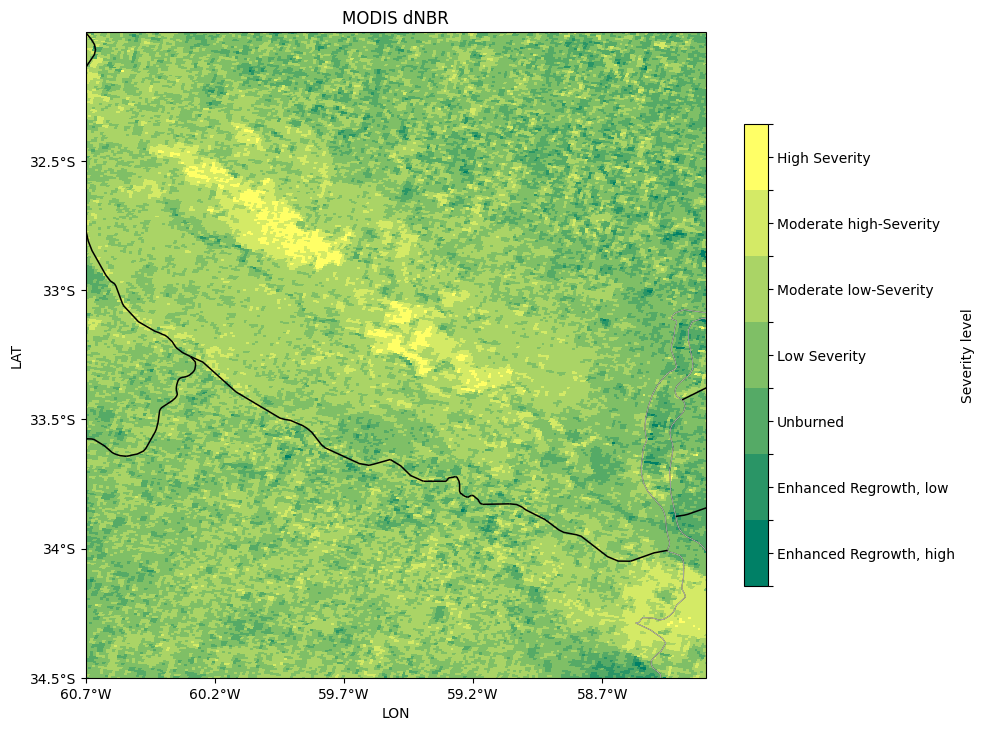

In [44]:
# Definimos los limites del area a visualizar
latnorth=-32
latsouth=-34.5
lonwest=-60.7
loneast=-58.3

fig=plt.figure(figsize=(10,10))
    
ax1 = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
    
# Definimos el área de graficado y a qué proyección hay que transformar las coordenadas lat/lon
    
ax1.set_extent([lonwest, loneast, latsouth, latnorth], crs=ccrs.PlateCarree())

# Graficamos
    
cm=ax1.pcolormesh(bef_fire_lon,bef_fire_lat, dnbr_modis_class,cmap=['summer, 'autum']'summer', norm = norm)

# Agregamos la línea de costas
ax1.coastlines(resolution='10m',linewidth=0.6)
    
# Agregamos los límites de los países
ax1.add_feature(countries,linewidth=0.4)
    
# Agregamos los límites de las provincias
ax1.add_feature(states_provinces,linewidth=1.1)

#Agregamos ejes
ax1.set_title("MODIS dNBR")
ax1.set_ylabel("LAT")
ax1.set_xlabel("LON")
    
# Definimos donde aparecen los ticks con las latitudes y longitudes
ax1.set_yticks(np.arange(latsouth,latnorth,0.5), crs=ccrs.PlateCarree())
ax1.set_xticks(np.arange(lonwest,loneast,0.5), crs=ccrs.PlateCarree())
    
# Le damos formato a las etiquetas de los ticks
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)

# Agregamos la barra de colores 
cbar=plt.colorbar(cm,shrink=0.6)
cbar.set_ticks(np.linspace(1, 7, 15))
cbar.set_ticklabels(dnbr_cat_names)
cbar.set_label('Severity level',fontsize=10)

### Grafico de barras
Para ver en que sección cae cada valor de NBR

In [20]:
height = []
#np.apend( height, values = [(i == np.ndarray.flatten(dnbr_modis_class)).sum() for i in np.linspace(1,7,8)])

In [21]:
for i in np.linspace(1,7,7): 
    val = (i == np.ndarray.flatten(dnbr_modis_class)).sum()
    height = np.append(arr = height ,values = val)

In [22]:
height

array([265394., 455405., 951171., 749198., 281747.,  44600.,   1105.])

ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (15,)  and requested shape (7,)

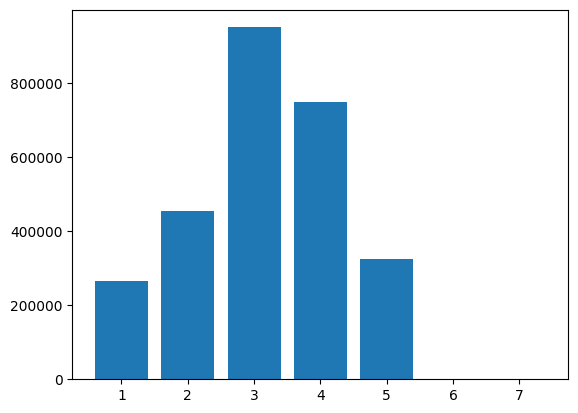

In [135]:
plt.bar(x = np.linspace(1,7,7), height = height, tick_label = dnbr_cat_names)